## 1 Clustering

### 1.2 Experiment

In [1]:
from itertools import permutations
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import accuracy_score

#### Data Set Information

In [2]:
sigma = [0.5, 1, 2, 4, 8]

mu = np.array([[-1, -1], [1, -1], [0, 1]])

var = np.zeros((3, 2, 2))
var[0] = np.array([[2, 0.5], [0.5, 1]])
var[1] = np.array([[1, -0.5], [-0.5, 2]])
var[2] = np.array([[1, 0], [0, 2]])

true_labels = np.repeat(range(3), 100)

#### K-means

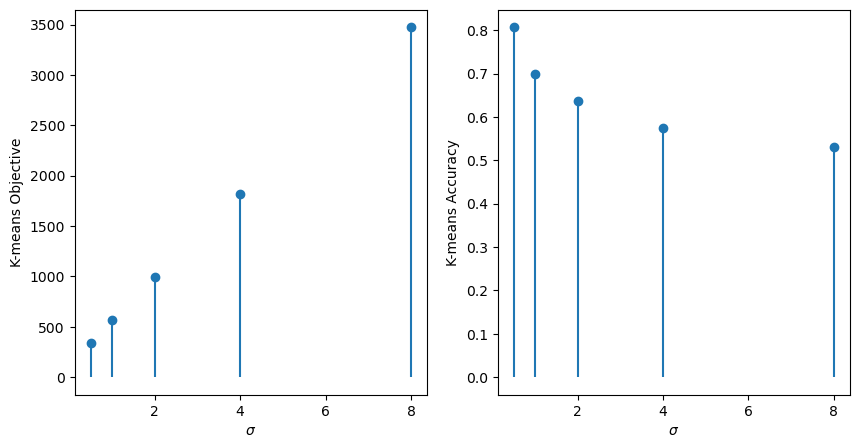

In [6]:
n_runs = 20
clustering_objective = np.zeros((len(sigma), n_runs))
clustering_accuracy = np.zeros((len(sigma), n_runs))

for i in range(len(sigma)):
    np.random.seed(1109)
    data = np.vstack((np.random.multivariate_normal(mu[0], var[0] * sigma[i], 100), 
                      np.random.multivariate_normal(mu[1], var[1] * sigma[i], 100), 
                      np.random.multivariate_normal(mu[2], var[2] * sigma[i], 100)))
    
    for j in range(n_runs):
        # k-means ++
        centers = np.zeros((3, 2))
        centers[0] = data[np.random.choice(300)] # 1st center

        s0 = np.sum((data - centers[0])**2, axis = 1)
        s0_new = s0 / np.max(s0)
        p = s0_new / np.sum(s0_new)
        centers[1] = data[np.random.choice(300, p = p)] # 2nd center

        s1 = np.sum((data - centers[1])**2, axis = 1)
        s = np.minimum(s0, s1)
        s_new = s / np.max(s)
        p = s_new / np.sum(s_new)
        centers[2] = data[np.random.choice(300, p = p)] # 3rd center

        for _ in range(100):
            distances = np.linalg.norm(data[:, np.newaxis] - centers, axis = 2)
            labels = np.argmin(distances, axis = 1)

            new_centers = np.array([data[labels == i].mean(axis = 0) for i in range(3)])

            # Check for convergence
            if np.all(centers == new_centers):
                break

            centers = new_centers

        clustering_objective[i, j] = np.sum((data - centers[labels])**2)

        acc = np.zeros(6)
        index = 0
        for cluster_num in list(permutations((0, 1, 2))):
            true_labels = np.repeat(cluster_num, 100)
            acc[index] = np.sum(labels == true_labels) / 300
            index += 1
        clustering_accuracy[i, j] = max(acc)

clustering_objective = np.min(clustering_objective, axis = 1)
clustering_accuracy = np.max(clustering_accuracy, axis = 1)

fig, axs = plt.subplots(1, 2, figsize = (10, 5))
axs[0].vlines(sigma, 0, clustering_objective)
axs[0].scatter(sigma, clustering_objective)
axs[0].set_xlabel(r'$\sigma$')
axs[0].set_ylabel('K-means Objective')

axs[1].vlines(sigma, 0, clustering_accuracy)
axs[1].scatter(sigma, clustering_accuracy)
axs[1].set_xlabel(r'$\sigma$')
axs[1].set_ylabel('K-means Accuracy')

plt.savefig('Kmeans.pdf', format = 'pdf')
plt.show()

#### Gaussian Mixture Models

In [3]:
class GMM:
    def __init__(self, data, true_labels, n_distributions, max_iter = 200, tolerance = 1e-8):
        self.X = data
        self.true_labels = true_labels
        self.n_distributions = n_distributions
        self.max_iter = max_iter
        self.tolerance = tolerance

    def EM(self):
        # E-step
        posterior = np.zeros((self.X.shape[0], self.n_distributions))
        for i in range(self.n_distributions):
            posterior[:, i] = self.weights[i] * multivariate_normal.pdf(self.X, self.means[i], self.covariances[i])
        posterior /= np.sum(posterior, axis = 1)[:, np.newaxis]
        # M-step
        w_sum = np.sum(posterior, axis = 0)
        self.weights = w_sum / self.X.shape[0]
        self.means = np.dot(posterior.T, self.X) / w_sum[:, np.newaxis]
        self.covariances = [np.dot(posterior[:, i] * (self.X - self.means[i]).T, self.X - self.means[i]) / w_sum[i] for i in range(self.n_distributions)]

    def log_likelihood(self):
        likelihoods = np.array([self.weights[i] * multivariate_normal.pdf(self.X, self.means[i], self.covariances[i]) for i in range(self.n_distributions)])
        return np.sum(np.log(np.sum(likelihoods, axis = 0)))

    def fit(self):
        self.weights = np.full(self.n_distributions, 1 / self.n_distributions)
        self.means = self.X[np.random.choice(self.X.shape[0], self.n_distributions, replace = False)]
        self.covariances = np.array([np.cov(self.X.T) for _ in range(self.n_distributions)])

        l = float('-inf') # Initialize log-likelihood
        for _ in range(self.max_iter):
            self.EM()
            # Check convergence
            new_l = self.log_likelihood() # New log-likelihood after EM
            if new_l - l < self.tolerance:
                break
            l = new_l # Update log-likelihood
                      
    def predict(self, new_points):
        likelihoods = np.array([self.weights[i] * multivariate_normal.pdf(new_points, self.means[i], self.covariances[i]) for i in range(self.n_distributions)])
        return np.argmax(likelihoods, axis = 0)
    
    def training_accuracy(self):
        fitted_labels = self.predict(self.X)
        return accuracy_score(self.true_labels, fitted_labels)
    
    def objective(self):
        return -self.log_likelihood()

In [4]:
gmm_objective = np.zeros(len(sigma))
gmm_accuracy = np.zeros(len(sigma))

for i in range(len(sigma)):
    np.random.seed(1109)
    data = np.vstack((np.random.multivariate_normal(mu[0], var[0] * sigma[i], 100), 
                      np.random.multivariate_normal(mu[1], var[1] * sigma[i], 100), 
                      np.random.multivariate_normal(mu[2], var[2] * sigma[i], 100)))
    
    gmm = GMM(data, true_labels, 3)
    gmm.fit()
    gmm_objective[i] = gmm.objective()
    gmm_accuracy[i] = gmm.training_accuracy()

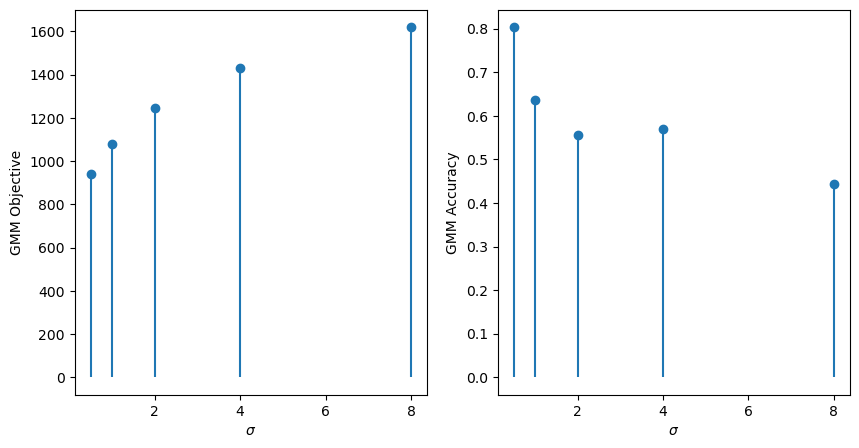

In [11]:
fig, axs = plt.subplots(1, 2, figsize = (10, 5))
axs[0].vlines(sigma, 0, gmm_objective)
axs[0].scatter(sigma, gmm_objective)
axs[0].set_xlabel(r'$\sigma$')
axs[0].set_ylabel('GMM Objective')

axs[1].vlines(sigma, 0, gmm_accuracy)
axs[1].scatter(sigma, gmm_accuracy)
axs[1].set_xlabel(r'$\sigma$')
axs[1].set_ylabel('GMM Accuracy')

plt.savefig('GMM.pdf', format = 'pdf')
plt.show()

## 2 Linear Dimensionality Reduction

In [1]:
import matplotlib.pyplot as plt
import numpy as np

### 2.3 Experiment

In [2]:
data2D = np.genfromtxt('data/data2D.csv', delimiter = ',')
data1000D = np.genfromtxt('data/data1000D.csv', delimiter = ',')

In [5]:
def PCA(data, dim, method):
    if method == 'buggy':
        _, _, VT = np.linalg.svd(data, full_matrices = False)
        A = VT[:dim].T # desired right singular vectors of the data matrix
        Z = data @ A # d-dimensional representations
        R = Z @ A.T # reconstructions
        return Z, A, R
    
    elif method == 'demeaned':
        data_mean = np.mean(data, axis = 0)
        demeaned_data = data - data_mean
        _, _, VT = np.linalg.svd(demeaned_data, full_matrices = False)
        A = VT[:dim].T # desired right singular vectors of the data matrix
        Z = demeaned_data @ A # d-dimensional representations
        R = Z @ A.T + data_mean # reconstructions
        return Z, A, R
    
    else:
        data_mean = np.mean(data, axis = 0)
        data_std = np.std(data, axis = 0)
        normalized_data = (data - data_mean) / data_std
        _, _, VT = np.linalg.svd(normalized_data, full_matrices = False)
        A = VT[:dim].T # desired right singular vectors of the data matrix
        Z = normalized_data @ A # d-dimensional representations
        R = Z @ A.T * data_std + data_mean # reconstructions
        return Z, A, R
    
    
def DRO(data, dim):
    b = np.mean(data, axis = 0)
    U, S, VT = np.linalg.svd(data - b, full_matrices = False)
    n = data.shape[0]
    Z = np.sqrt(n) * U[:, :dim]
    A = VT[:dim].T * S[:dim] / np.sqrt(n)
    R = Z @ A.T + b # reconstructions
    return Z, A, b, R

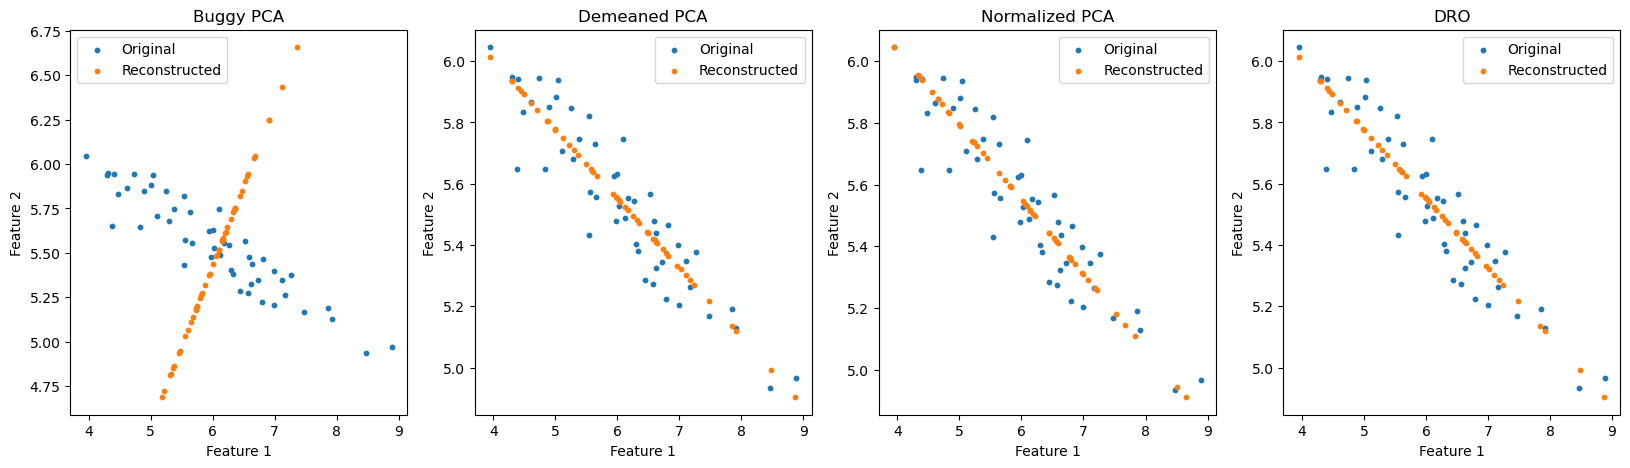

In [9]:
_, _, R1 = PCA(data2D, 1, 'buggy')
_, _, R2 = PCA(data2D, 1, 'demeaned')
_, _, R3 = PCA(data2D, 1, 'normalized')
_, _, _, R4 = DRO(data2D, 1)


fig, axs = plt.subplots(1, 4, figsize = (20, 5))
axs[0].scatter(data2D[:, 0], data2D[:, 1], s = 10, label = 'Original')
axs[0].scatter(R1[:, 0], R1[:, 1], s = 10, label = 'Reconstructed')
axs[0].set_xlabel('Feature 1')
axs[0].set_ylabel('Feature 2')
axs[0].set_title('Buggy PCA')
axs[0].legend()

axs[1].scatter(data2D[:, 0], data2D[:, 1], s = 10, label = 'Original')
axs[1].scatter(R2[:, 0], R2[:, 1], s = 10, label = 'Reconstructed')
axs[1].set_xlabel('Feature 1')
axs[1].set_ylabel('Feature 2')
axs[1].set_title('Demeaned PCA')
axs[1].legend()

axs[2].scatter(data2D[:, 0], data2D[:, 1], s = 10, label = 'Original')
axs[2].scatter(R3[:, 0], R3[:, 1], s = 10, label = 'Reconstructed')
axs[2].set_xlabel('Feature 1')
axs[2].set_ylabel('Feature 2')
axs[2].set_title('Normalized PCA')
axs[2].legend()

axs[3].scatter(data2D[:, 0], data2D[:, 1], s = 10, label = 'Original')
axs[3].scatter(R4[:, 0], R4[:, 1], s = 10, label = 'Reconstructed')
axs[3].set_xlabel('Feature 1')
axs[3].set_ylabel('Feature 2')
axs[3].set_title('DRO')
axs[3].legend()

plt.savefig('data2D.pdf', format = 'pdf')
plt.show()

In [7]:
data2D_errors = np.zeros(4)
data2D_errors[0] = np.mean(np.sum((data2D - R1)**2, axis = 1))
data2D_errors[1] = np.mean(np.sum((data2D - R2)**2, axis = 1))
data2D_errors[2] = np.mean(np.sum((data2D - R3)**2, axis = 1))
data2D_errors[3] = np.mean(np.sum((data2D - R4)**2, axis = 1))
print(data2D_errors)

[0.88690308 0.01000609 0.04947208 0.01000609]


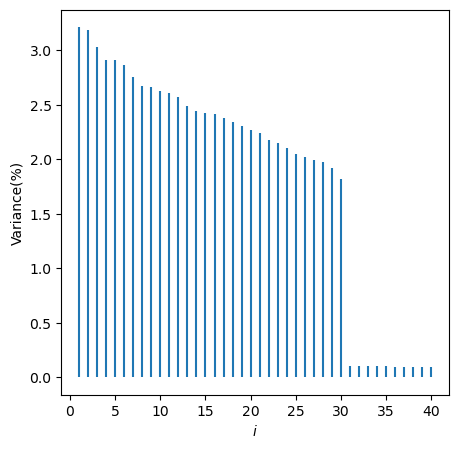

In [11]:
b = np.mean(data1000D, axis = 0)
S = np.linalg.svd(data1000D - b, compute_uv = False)

fig, ax = plt.subplots(figsize = (5, 5))
ax.vlines(range(1, 41), 0, S[:40]/sum(S) * 100)
ax.set_xlabel(r'$i$')
ax.set_ylabel('Variance(%)')
plt.savefig('dim.pdf', format = 'pdf')
plt.show()

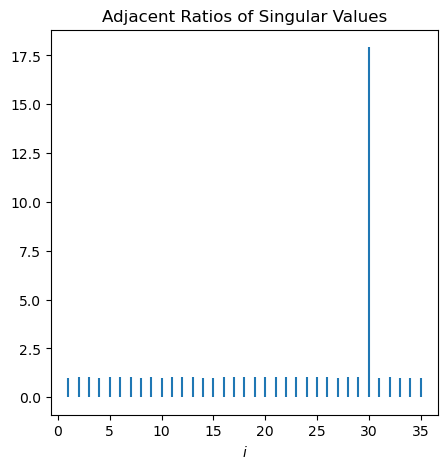

In [12]:
b = np.mean(data1000D, axis = 0)
S = np.linalg.svd(data1000D - b, compute_uv = False)
max_index = 35
adjacent_ratios = S[:max_index] / S[1:max_index+1]

fig, ax = plt.subplots(figsize = (5, 5))
ax.vlines(range(1, len(adjacent_ratios)+1), 0, adjacent_ratios)
# ax.scatter(range(1, len(adjacent_ratios)+1), adjacent_ratios)
ax.set_xlabel(r'$i$')
ax.set_title('Adjacent Ratios of Singular Values')

# plt.savefig('GMM.pdf', format = 'pdf')
plt.show()

In [16]:
print(sum(S[:30]) / sum(S))

0.7349614069771947


In [8]:
d = 30 # selected dimension

_, _, R1 = PCA(data1000D, d, 'buggy')
_, _, R2 = PCA(data1000D, d, 'demeaned')
_, _, R3 = PCA(data1000D, d, 'normalized')
_, _, _, R4 = DRO(data1000D, d)

data1000D_errors = np.zeros(4)
data1000D_errors[0] = np.mean(np.sum((data1000D - R1)**2, axis = 1))
data1000D_errors[1] = np.mean(np.sum((data1000D - R2)**2, axis = 1))
data1000D_errors[2] = np.mean(np.sum((data1000D - R3)**2, axis = 1))
data1000D_errors[3] = np.mean(np.sum((data1000D - R4)**2, axis = 1))
print(data1000D_errors)

[802.73139862 273.04595898 273.628581   273.04595898]
